In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import sys
from tqdm import tqdm
import pickle
from pathlib import Path
import bilby

# Add module
sys.path.append('../../modules')
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *

from constants import *

from pygwb.constants import H0
import equations
import redshiftPrior

from loguru import logger

import lal
lal.swig_redirect_standard_output_error(False)

import montecarlo as hf

In [2]:
# # Plot formatting
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# fontsize = 9
# params = {
#    'axes.labelsize': fontsize,
#    'font.size': fontsize,
#    'legend.fontsize': 8,
#    'xtick.labelsize': fontsize,
#    'ytick.labelsize': fontsize,
#    'axes.titlesize': fontsize,
#    'lines.linewidth': 1,  
#    'xtick.direction': 'in',
#    'ytick.direction': 'in',
#    'font.family': 'Serif',
#    'font.serif': 'Hoefler Text',
#    'axes.grid': True,
#    'figure.figsize': (6.75, 4),
#    'figure.dpi': 250,
#    'mathtext.fontset': 'cm'
# }

# for param in params.keys():
#     matplotlib.rcParams[param] = params[param]  

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 18
# ALWAYS USE figsize = (3.375, X) for column plots 
# figsize = (6.75, X) for rows 
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 12,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]    

# Helper Functions

# Parameters

In [4]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

fs = 4096

# Data Simulation Parameters
T_obs = .1 # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
sampling_frequency = 4096 # sampling rate (in Hz)
num_iterations = 50 # number of iterations to average Omega(f) over

z_max = 20

N_inj = 100_000 # number of injections that we will then reweight

In [5]:
# Standard Prior Dictionary
# Prior dictionary for priors we *want* to calculate omega_gw for
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.8, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors['luminosity_distance']
del priors['chirp_mass']

# "Reference" prior dictionary
ref_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# uniform_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max)
ref_priors['mass_ratio'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
ref_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
ref_priors['chi_1'] = 0
ref_priors['chi_2'] = 0
ref_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp,
                                                                       minimum=0, maximum=z_max, name='redshift')
ref_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del ref_priors['luminosity_distance']
del ref_priors['chirp_mass']

23:57 bilby INFO    : Using aligned spin prior
23:57 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.
23:57 bilby INFO    : Using aligned spin prior
23:57 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [6]:
# Calculate number of injections
zs, p_dz = priors['redshift']._get_redshift_arrays()
print(zs)
N = hf.calculate_num_injections(T_obs, priors).value
print(N)

[0.0000000e+00 1.0006003e-02 2.0012006e-02 ... 1.9981988e+01 1.9991994e+01
 2.0002000e+01]
4856.7039176108765


# Gridded Method

## Calculate Gridded Method

In [7]:
# Gridded Method
# Set up OmegaGW object
inspiralOnly = False
m1_min = BBH_min
m1_max = BBH_max
m2_min = BBH_min
m2_max = BBH_max
minimum_component_mass = BBH_min
maximum_component_mass = BBH_max


In [8]:
if Path('callister_omg_object.pickle').exists():
    print("Loading pickle...")
    omg = pickle.load(open('callister_omg_object.pickle', 'rb'))
else:
    omg = OmegaGW_BBH(minimum_component_mass, maximum_component_mass, zs)
    pickle.dump(omg, open('callister_omg_object.pickle', 'wb'))

OSError: [Errno 28] No space left on device

In [ ]:
# Calculate merger rate
# mergerRate = equations.get_R_array(zs, alpha, beta, zp, R0)
# mergerRate2 = equations.get_R_array(omg.ref_zs, alpha, beta, zp, R0)
rate = priors['redshift']._get_rate_vs_redshift(omg.ref_zs)
freqs_TC = np.arange(0, 2048.5, 0.5)

# Calculate probability grid
# Priors defined in (m1, q) space
probs = np.empty((omg.m1s_2d.shape[0], omg.qs_2d.shape[1])) # initialize array
for i in tqdm(range(omg.m1s_2d.shape[0])): # for each m1
    for j in range(omg.qs_2d.shape[1]): # for each q
        prob = priors.prob({'mass_1':omg.m1s_2d[i][j], 'mass_ratio':omg.qs_2d[i][j]}) # calculate probability
        probs[i][j] = prob # insert probability into probability array
probs = probs*(omg.Mtots_2d/(1. + omg.qs_2d)) # multiply by the Jacobian

# Limit probabilities to physical masses
probs[omg.m1s_2d < m1_min] = 0
probs[omg.m1s_2d > m1_max] = 0
probs[omg.m2s_2d < m2_min] = 0
probs[omg.m2s_2d > m2_max] = 0

# Normalize probabilities
probs /= np.sum(probs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 151.36it/s]


In [ ]:
omg.probs = probs
OmegaGW_TC = omg.eval(R0, rate * 1e9, freqs_TC)

## Plot Gridded Method

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/pw/q58shg_d4vz37qn56ds0zjm40000gn/T/ipykernel_78291/3613230569.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


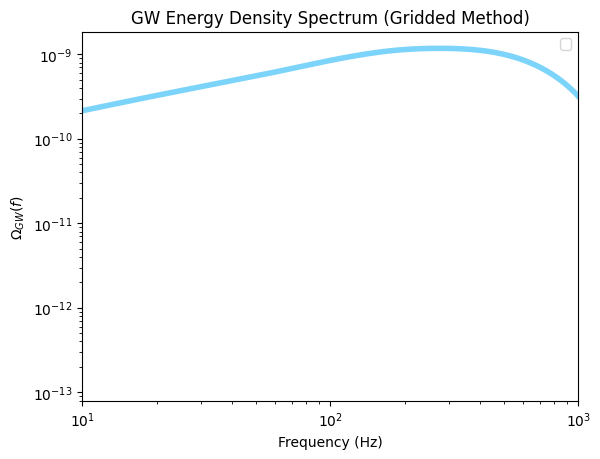

In [ ]:
# Plot
fig, ax = plt.subplots()
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa', lw=4)
ax.set_title(r'GW Energy Density Spectrum (Gridded Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1000)
plt.ylim(1e-10, 1e-8)
ax.legend()
fig.show()

# Monte carlo method

In [ ]:
# Regimbau Method
OmegaGW_AR = []
for i in range(num_iterations):
    freqs_psd, omega_gw_freq = hf.monteCarlo(priors, Tobs=T_obs, duration=2, f_ref=25, sampling_frequency=fs, approximant='IMRPhenomD')
    OmegaGW_AR.append(omega_gw_freq)



2024-04-15 17:28:25.974 | INFO     | montecarlo:draw_injections:114 - We are averaging over 4856.7039176108765 1 / yr waveforms for 0.1 years
17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:02<00:00, 1776.39it/s]
2024-04-15 17:28:28.867 | INFO     | montecarlo:draw_injections:114 - We are averaging over 4856.7039176108765 1 / yr waveforms for 0.1 years
17:28 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|██

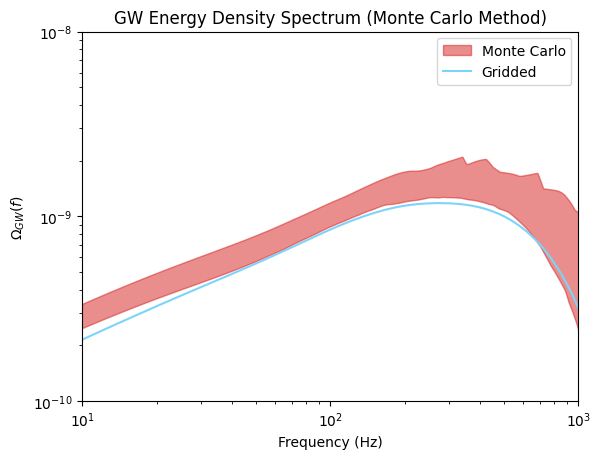

In [ ]:
# Plot spectrum
plt.subplots()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(freqs_psd, np.percentile(OmegaGW_AR, 5, axis=0), np.percentile(OmegaGW_AR, 95, axis=0), color='#d61c1c', alpha=0.5, label='Monte Carlo')
ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa', label='Gridded')
ax.set_xlim(10, 1000)
ax.set_ylim(1e-10,1e-8)
ax.set_title(r'GW Energy Density Spectrum (Monte Carlo Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.legend()

# Reweighting Method

## Reweighting Method Code

In [ ]:
# N_inj = int(N)
omgw_rw = []
for ii in range(50):
    N_inj = 5000
    T_obs = 0.1
    # injections = draw_injections(ref_priors, T_obs)
    injections = ref_priors.sample(N_inj)
    N_inj = len(injections['mass_1'])
    print(T_obs)
    # Draw injections
    # injections = priors.sample(N_inj)
    
    m1s = injections['mass_1']
    qs = injections['mass_ratio']
    zvals = injections['redshift']
    
    # Set up waveform generator
    # Waveform generator parameters
    sampling_frequency=sampling_frequency
    approximant='IMRPhenomD'
    dEdfs, freqs = hf.get_dedf(injections, sampling_frequency=sampling_frequency, approximant=approximant)
    weights = hf.get_weights(dEdfs, ref_priors, priors, zvals, m1s, qs)
    h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)
    # weighted sum of h+^2 + hx^2 over vents
    dEdf_sum = dEdfs.T @ weights
    
    # total rate for the priors we want Omega_{gw} for
    total_rate = hf.calculate_total_rate(priors).value / (86400 * 365.25) # in units of [events s^{-1}]
    print(total_rate)
    
    
    OmegaGW_W = 2 * np.pi**2 * freqs**3 * dEdf_sum / (3 * h0.value**2)
    Tobs_seconds = T_obs * 86400 * 365.25  # years to seconds
    
    # replace [1 / Tobs] by [rate / N_inj]
    OmegaGW_W *= 2 * total_rate / N_inj
    omgw_rw.append(OmegaGW_W)

17:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1832.29it/s]
17:30 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2701.73it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2780.68it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2776.38it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2759.44it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2812.31it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2752.11it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2823.91it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2848.39it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2841.47it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2794.65it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2831.73it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2826.28it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2718.39it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2830.02it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2801.55it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2724.11it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2755.88it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2685.82it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2816.50it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2882.50it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2874.78it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2730.56it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2784.98it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2795.59it/s]
17:31 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2852.18it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2784.72it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2867.78it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2858.84it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2870.49it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2830.94it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2794.44it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2888.96it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2863.64it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2819.81it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2852.86it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2885.61it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2856.24it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2858.17it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2861.63it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2847.00it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2825.71it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2892.07it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2881.69it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2882.64it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2847.81it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2723.40it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2798.41it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2748.52it/s]
17:32 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


0.0015389966022799186
0.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2755.05it/s]


0.0015389966022799186


In [ ]:
# Plot spectrum
# plt.figure(figsize=(11, 7))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.loglog(freqs_TC, OmegaGW_TC, color='k',lw=4, label='Gridded')
ax.fill_between(freqs_psd, np.percentile(OmegaGW_AR, 5, axis=0), np.percentile(OmegaGW_AR, 95, axis=0), color='#d61c1c', alpha=0.5, label='Monte Carlo')
ax.fill_between(freqs_psd, np.percentile(omgw_rw, 5, axis=0), np.percentile(omgw_rw, 95, axis=0), color='#25cc33', alpha=0.5, label='Weighted')
ax.set_xlim(10, 1000)
ax.set_ylim(1e-10,1e-8)
ax.set_title(r'GW Energy Density Spectrum')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
plt.savefig("method_comparison.pdf")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Plot spectrum
# Find OmegaGW(fref)
fref = 25
fref_approx_AR = 100
fref_approx_index_AR = 0
for i in range(len(freqs_psd)):
    if(np.absolute(freqs_psd[i] - fref) < fref_approx_AR):
        fref_approx_AR = np.absolute(freqs_psd[i] - fref)
        fref_approx_index_AR = i
Omega_ref_AR = np.sum(OmegaGW_AR, axis=0)[fref_approx_index_AR]
diff = (Omega_ref_AR*np.divide(freqs_psd,fref)**(2/3))[50]-np.percentile(OmegaGW_AR, 50, axis=0)[50]
diff = diff*np.ones(len(freqs_psd))
plt.subplots()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.loglog(freqs_TC, OmegaGW_TC, color='k',lw=4, label='Gridded')
ax.loglog(freqs_psd, Omega_ref_AR*np.divide(freqs_psd,fref)**(2/3)/10, '-', label='2/3 Power Law', color='#000000')
ax.loglog(freqs_psd, Omega_ref_AR*np.divide(freqs_psd,fref)**(1/2)/10, '--', label='1/2 Power Law', color='#888888')
ax.set_xlim(10, 1000)
ax.set_ylim(1e-9,1e-6)
ax.set_title(r'GW Energy Density Spectrum (Gridded Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.legend()

In [ ]:
# Plot spectrum
# Find OmegaGW(fref)
fref = 25
fref_approx_AR = 100
fref_approx_index_AR = 0
for i in range(len(freqs_psd)):
    if(np.absolute(freqs_psd[i] - fref) < fref_approx_AR):
        fref_approx_AR = np.absolute(freqs_psd[i] - fref)
        fref_approx_index_AR = i
Omega_ref_AR = np.sum(OmegaGW_AR, axis=0)[fref_approx_index_AR]
diff = (Omega_ref_AR*np.divide(freqs_psd,fref)**(2/3))[50]-np.percentile(OmegaGW_AR, 50, axis=0)[50]
diff = diff*np.ones(len(freqs_psd))
plt.subplots()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(freqs_psd, np.percentile(OmegaGW_AR, 50, axis=0), np.percentile(OmegaGW_AR, 50, axis=0), color='#d61c1c', alpha=0.5)
ax.loglog(freqs_psd, Omega_ref_AR*np.divide(freqs_psd,fref)**(2/3)/10, '-', label='2/3 Power Law', color='#000000')
ax.loglog(freqs_psd, Omega_ref_AR*np.divide(freqs_psd,fref)**(1/2)/10, '--', label='1/2 Power Law', color='#888888')
ax.set_xlim(10, 1000)
ax.set_ylim(1e-9,1e-6)
ax.set_title(r'GW Energy Density Spectrum (Monte Carlo Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.legend()

In [ ]:
fref = 25
fref_approx_W = 100
fref_approx_index_W = 0
for i in range(len(freqs_W)):
    if(np.absolute(freqs_W[i] - fref) < fref_approx_W):
        fref_approx_W = np.absolute(freqs_W[i] - fref)
        fref_approx_index_W = i
Omega_ref_W = np.sum(OmegaGW_Ws, axis=0)[fref_approx_index_W]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(freqs_W, np.percentile(OmegaGW_Ws, 50, axis=0), np.percentile(OmegaGW_Ws, 50, axis=0), color='#25cc33', alpha=0.3)
ax.loglog(freqs_W, Omega_ref_W*np.divide(freqs_W,fref)**(2/3)/11, '-', label='2/3 Power Law', color='#000000')
ax.loglog(freqs_W, Omega_ref_W*np.divide(freqs_W,fref)**(1/2)/11, '--', label='1/2 Power Law', color='#888888')
ax.set_title(r'GW Energy Density Spectrum (Weighted Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 1024)
ax.set_ylim(1e-10,1e-8)
ax.legend()